### Import modules and Load data

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
!pip install kaggledatasets

In [10]:
!kaggle datasets download -d cashbowman/ai-generated-images-vs-real-images

ai-generated-images-vs-real-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [12]:
import os

!rm -rf data/
!unzip -q ai-generated-images-vs-real-images.zip -d data/

os.mkdir(os.path.join('data', 'train'))
os.mkdir(os.path.join('data', 'test'))

def train_test_split(data_dir, train_size=0.8, shuffle=True):
    '''
    Splits the data into train and test sets

    Args:
    data_dir: str, path to the data directory, with folder names as the class names
    train_size: float, size of the training set
    shuffle: bool, whether to shuffle the data or not

    Returns:
    train_data_dir: directory containing the training data
    test_data_dir: directory containing the testing data
    '''
    for class_name in os.listdir(data_dir):
        if class_name == 'AiArtData':
            class_name_new = 'fake'
        elif class_name == 'RealArt':
            class_name_new = 'real'
        os.mkdir(os.path.join('data', 'train', class_name_new))
        os.mkdir(os.path.join('data', 'test', class_name_new))

        class_dir = os.path.join(data_dir, class_name)
        all_files = os.listdir(class_dir)

        if shuffle:
            np.random.shuffle(all_files)

        train_files = all_files[:int(train_size * len(all_files))]
        test_files = all_files[int(train_size * len(all_files)):]

        for file in train_files:
            os.rename(os.path.join(class_dir, file), os.path.join('data', 'train', class_name_new, file))

        for file in test_files:
            os.rename(os.path.join(class_dir, file), os.path.join('data', 'test', class_name_new, file))  
    os.rmdir(data_dir+f'/{class_name}/')
    os.rmdir(data_dir)

In [13]:
train_test_split('data/AiArtData')
train_test_split('data/RealArt')

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img / 255.)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (946, 1419, 3)


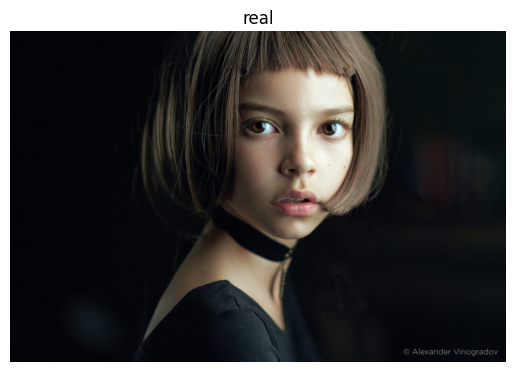

In [15]:
img = view_random_image('data/train/', 'real')

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

In [17]:
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_dir = 'data/train'
test_dir = 'data/test'

train_data = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(224, 224),
                                                  batch_size=32,
                                                  class_mode='binary',
                                                  seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary',
                                                    seed=42)

Found 777 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [18]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

2024-03-22 06:10:30.499701: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 06:10:30.499897: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-22 06:10:30.500001: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
model_1.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 10)        0

In [20]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


2024-03-22 06:10:32.304489: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-22 06:10:32.382360: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-22 06:10:32.382372: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-03-22 06:10:32.382399: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-22 06:10:32.492356: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-03-22 06:10:32.515541: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

 9/25 [=========>....................] - ETA: 3s - loss: 0.6940 - accuracy: 0.5132

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 9s 341ms/step - loss: 0.6807 - accuracy: 0.5393 - val_loss: 0.6766 - val_accuracy: 0.5596
Epoch 2/5
25/25 [==============================] - 8s 333ms/step - loss: 0.6448 - accuracy: 0.6384 - val_loss: 0.6465 - val_accuracy: 0.6321
Epoch 3/5
25/25 [==============================] - 8s 336ms/step - loss: 0.5928 - accuracy: 0.6795 - val_loss: 0.6307 - val_accuracy: 0.6528
Epoch 4/5
25/25 [==============================] - 8s 327ms/step - loss: 0.5492 - accuracy: 0.7220 - val_loss: 0.6977 - val_accuracy: 0.5855
Epoch 5/5
25/25 [==============================] - 8s 339ms/step - loss: 0.5288 - accuracy: 0.7375 - val_loss: 0.5812 - val_accuracy: 0.7150


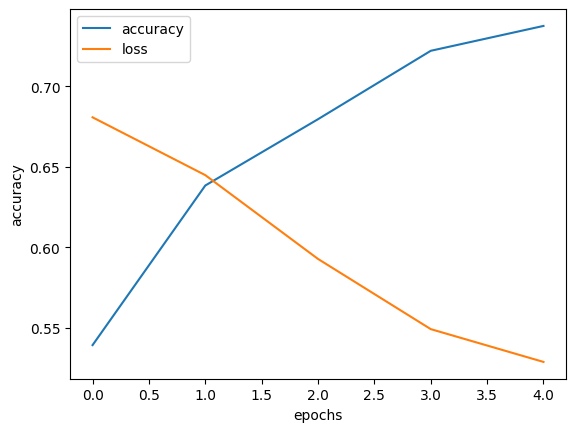

In [25]:
plt.plot(history_1.history['accuracy'], label='accuracy')
plt.plot(history_1.history['loss'], label='loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

In [26]:
model_1.evaluate(test_data)

7/7 [==============================] - 2s 256ms/step - loss: 0.5812 - accuracy: 0.7150


[0.5812017917633057, 0.7150259017944336]

In [34]:
model_2 = tf.keras.models.Sequential([
    #tf.keras.layers.Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
    #tf.keras.layers.MaxPool2D(pool_size=2),
    #tf.keras.layers.Conv2D(10, 3, activation='relu'),
    #tf.keras.layers.MaxPool2D(pool_size=2),
    #f.keras.layers.Conv2D(10, 3, activation='relu'),
    #tf.keras.layers.MaxPool2D(pool_size=2),
    #tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(1, activation='sigmoid')
    tf.keras.layers.Conv2D(20, 3, activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(20, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [35]:
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 20)      560       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 20)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 20)      3620      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 54, 54, 20)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 20)        3620      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 26, 26, 20)       

In [36]:
history_2 = model_2.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=len(test_data))

Epoch 1/5
21/25 [========================>.....] - ETA: 0s - loss: 0.7141 - accuracy: 0.4926

/opt/anaconda3/envs/TensorFlow/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


25/25 [==============================] - 9s 336ms/step - loss: 0.7123 - accuracy: 0.4865 - val_loss: 0.6834 - val_accuracy: 0.5492
Epoch 2/5
25/25 [==============================] - 8s 329ms/step - loss: 0.6771 - accuracy: 0.5534 - val_loss: 0.6840 - val_accuracy: 0.5648
Epoch 3/5
25/25 [==============================] - 8s 332ms/step - loss: 0.6664 - accuracy: 0.5560 - val_loss: 0.6740 - val_accuracy: 0.5544
Epoch 4/5
25/25 [==============================] - 8s 336ms/step - loss: 0.6465 - accuracy: 0.5804 - val_loss: 0.6867 - val_accuracy: 0.5907
Epoch 5/5
25/25 [==============================] - 8s 340ms/step - loss: 0.6305 - accuracy: 0.6486 - val_loss: 0.6762 - val_accuracy: 0.5803


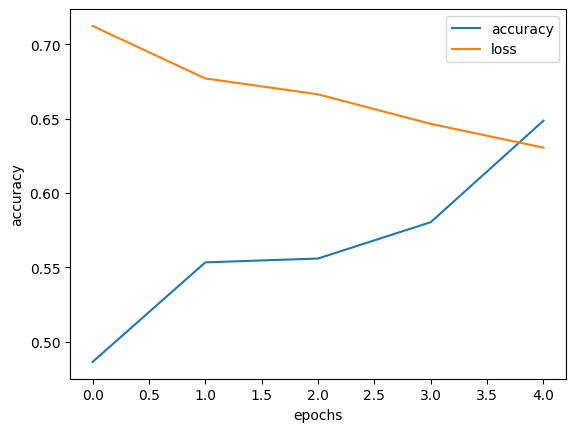

In [37]:
plt.plot(history_2.history['accuracy'], label='accuracy')
plt.plot(history_2.history['loss'], label='loss')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();